In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:2


In [3]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device,
    'noise':             0.5 # Set to 0 to not train on noisy features
}

# Hyperparameter optimized for 9/7

# args = {
#     'processor':         'GENConv',
#     'head':              'regression',     
#     'num_layers':        4,
#     'num_mlp_layers':    2,
#     'aggr':              'max',
#     'batch_size':        8,
#     'node_feature_dim':  5,
#     'edge_feature_dim':  1,
#     'graph_feature_dim': 2,
#     'hidden_dim':        58,
#     'output_dim':        1,
#     'dropout':           0.066,
#     'epochs':            80,
#     'opt':               'adagrad',
#     'opt_scheduler':     'none',
#     'opt_restart':       0,
#     'weight_decay':      5e-3,
#     'lr':                0.0022434,
#     'device':            device,
#     'noise':             0 # Set to 0 to not train on noisy features
# }

# Hyperparam optimized for 6,10

args = {
    'processor':         'GENConv',
    'head':              'regression',     
    'num_layers':        5,
    'num_mlp_layers':    5,
    'aggr':              'max',
    'batch_size':        2,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        128,
    'output_dim':        1,
    'dropout':           0.0115,
    'epochs':            32,
    'opt':               'adagrad',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0083,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

# Hyperparam optimized for 10,6

args = {
    'processor':         'GENConv',
    'head':              'regression',     
    'num_layers':        3,
    'num_mlp_layers':    3,
    'aggr':              'max',
    'batch_size':        8,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        32,
    'output_dim':        1,
    'dropout':           0.0306,
    'epochs':            20,
    'opt':               'adagrad',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0121,
    'device':            device,
    'noise':             0.5 # Set to 0 to not train on noisy features
}

In [4]:
train_num = 200; test_num = 100
train_num = 50; test_num = 40
node_config = (30,10)

# er_config = {
#     'graph_type': 'ER',
#     'p': 0.75,
#     'weighted': True
# }
# ba_config = {
#     'graph_type': 'BA',
#     'ba_param': 2,
#     'weighted': True
# }
# geom_config = {
#     'graph_type': 'GEOM',
#     'threshold': 0.2,
#     'scaling': 1 / np.sqrt(2)
# }

geom_config = {
        'graph_type': 'GEOM',
        'q': 0.15,
        'd': 2,
        'weighted': True
}


rng = np.random.default_rng(10)

train_instances = [
        # *ig.sample_instances(*node_config, train_num, rng, args, **er_config),
        # *ig.sample_instances(*node_config, train_num, rng, args, **ba_config),
        *ig.sample_instances(*node_config, train_num, rng, args, **geom_config),
    ]

test_instances = [
        # *ig.sample_instances(*node_config, test_num, rng, args, **er_config),
        # *ig.sample_instances(*node_config, test_num, rng, args, **ba_config),
        *ig.sample_instances(*node_config, test_num, rng, args, **geom_config),
    ]


# train_instances = [
#         ig.sample_instances(node_config[0], node_config[1], train_num, rng, args, **graph_config)
#         for graph_config in graph_configs
#         for node_config in node_configs
# ]
# test_instances = [
#         ig.sample_instances(node_config[0], node_config[1], test_num, rng, args, **graph_config)
#         for graph_config in graph_configs
#         for node_config in node_configs
# ]
# # flat map the instances
# train_instances = [instance for instances in train_instances for instance in instances]
# test_instances = [instance for instances in test_instances for instance in instances]

train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [6]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/20 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
/home/alexhay/GNN-OBM/gnn_library/util.py:39: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(preds, value_to_go)


torch.Size([23])
torch.Size([23])
torch.Size([20])
torch.Size([20])
torch.Size([21])
torch.Size([21])
torch.Size([19])
torch.Size([19])
torch.Size([18])
torch.Size([20])


Training:   0%|          | 0/20 [00:00<?, ?Epochs/s]


RuntimeError: The size of tensor a (18) must match the size of tensor b (20) at non-singleton dimension 0

In [9]:
save(GNN, args, 'GNN2_hyperparam_tuned')

In [ ]:
# GNN, args = load('GNN2', device)

In [ ]:
from gnn_library.OBM_greedy import OBM_Greedy
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = [(threshold, OBM_Threshold_Greedy(threshold)) for threshold in thresholds]

seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

greedy_ratios = {}
for threshold, model in thresholded_greedy_models: 
    ratio = evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=eval_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
pp_output(ratios2, _, show_log=False)
print(greedy_ratios)

In [ ]:
max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(max_threshold, greedy_ratios[max_threshold])

# Pivot to feature-generated graphs

In [ ]:
def get_location_graph(city):
	location_graph = ox.graph_from_place(city, network_type="drive")
	location_graph = ox.speed.add_edge_speeds(location_graph)
	location_graph = ox.speed.add_edge_travel_times(location_graph)
	return {'location_graph': location_graph, 'city': city}

In [ ]:
piedmont = get_location_graph("Piedmont, California, USA")
# san_francisco = get_location_graph("San Francisco, California, USA")
founex = get_location_graph("Founex, Switzerland")
carmel = get_location_graph("Carmel, Indiana, USA")
geneva = get_location_graph("Geneva, Switzerland")

In [ ]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 0.75,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
# osmnx_config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **er_config),
        *ig.sample_instances(8, 8, train_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(8, 8, test_num, rng, **er_config),
        *ig.sample_instances(8, 8, test_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [22]:
from tqdm import tqdm
import util
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

# osmnx_config1 = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# osmnx_config2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': geneva['location_graph']
# }
# osmnx_config3 = {
#     'graph_type': 'OSMNX',
#     'location_graph': carmel['location_graph']
# }

node_configs = util.node_configs_GNN1
graph_configs = util.graph_configs_standard
train_num = 5
train_instances = [
        ig.sample_instances(node_config[0], node_config[1], train_num, rng, args.__dict__, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]

# flat map the train instances
train_instances = [instance for instances in train_instances for instance in instances]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio, _ = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio['learned'])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

100%|██████████| 101/101 [29:33<00:00, 17.56s/it]

Best threshold value: 0.0 achieves CR: 0.05581373962215269


In [16]:
print(greedy_ratios)

{0.0: 0.991188005856922, 0.01: 0.991188005856922, 0.02: 0.991188005856922, 0.03: 0.991188005856922, 0.04: 0.991188005856922, 0.05: 0.991188005856922, 0.06: 0.991188005856922, 0.07: 0.991188005856922, 0.08: 0.991188005856922, 0.09: 0.991188005856922, 0.1: 0.991188005856922, 0.11: 0.991188005856922, 0.12: 0.991188005856922, 0.13: 0.991188005856922, 0.14: 0.991188005856922, 0.15: 0.991188005856922, 0.16: 0.991188005856922, 0.17: 0.991188005856922, 0.18: 0.991188005856922, 0.19: 0.991188005856922, 0.2: 0.991188005856922, 0.21: 0.991188005856922, 0.22: 0.991188005856922, 0.23: 0.991188005856922, 0.24: 0.991188005856922, 0.25: 0.9902019295044397, 0.26: 0.9902019295044397, 0.27: 0.9902019295044397, 0.28: 0.9902019295044397, 0.29: 0.9902019295044397, 0.3: 0.9902019295044397, 0.31: 0.9902019295044397, 0.32: 0.9902019295044397, 0.33: 0.9902019295044397, 0.34: 0.9902019295044397, 0.35000000000000003: 0.9902019295044397, 0.36: 0.9902019295044397, 0.37: 0.9902019295044397, 0.38: 0.9843320526626002,

## Evaluation

In [ ]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 25
eval_instances = [
        *ig.sample_instances(m, n, eval_num, rng, **er_config),
        *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
]

ratios = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)


ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[THRESHOLD_MODEL],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)
print(f"Thresholded greedy: {np.mean(ratios2[0]).round(4)}")


## Box plot baseline evaluation

In [4]:
GNN, args = load('GNN1_hyperparam_tuned', device)

In [32]:
import gnn_library.util as util
num_trials = 40
threshold = 0 # TODO set up value
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

models = [("GNN", GNN)]
t_greedy = OBM_Threshold_Greedy(threshold) 

node_configs = util.node_configs_gnn1
graph_configs = util.graph_configs_standard

data = {node_config: {} for node_config in node_configs}

for node_config in node_configs:
    for graph_config in graph_configs:
            print(graph_config)
            seed = np.random.randint(0, 500000)
            rng = np.random.default_rng(seed)
            instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


            rng = np.random.default_rng(seed)

            for model_name, model in models:
                cr_ratios, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[model],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=5,
                    baselines=['greedy', 'lp_rounding'],
                )

                data[node_config][graph_config['graph_type']] = cr_ratios

                t_greedy_ratio, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[t_greedy],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=5,
                )

                # Threshold greedy is considered as a model here
                data[node_config][graph_config['graph_type']]['threshold_greedy'] = t_greedy_ratio['learned']


{'graph_type': 'ER', 'p': 0.5, 'weighted': True}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'graph_type': 'ER', 'p': 0.75, 'weighted': True}
{'graph_type': 'ER', 'p': 0.9, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
{'graph_type': 'OSMNX', 'location': 'Piedmont, California, USA'}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
{'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'graph_type': 'ER', 'p': 0.5, 'weighted': True}
{'graph_type': 'ER', 'p': 0.75, 'weighted': True}
{'graph_type': 'ER', 'p': 0.9, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
{'graph_type': 'OSMNX', 'location': 'Piedmont, California, USA'}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
{'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
import pickle

with open(f"saved_runs/box_plot_eval_gnn1_base_2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open(f'saved_runs/box_plot_eval_gnn1_base_2.pickle', 'rb') as handle:
    data_copy = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


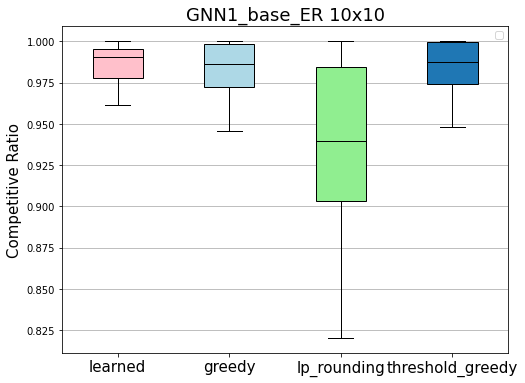

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


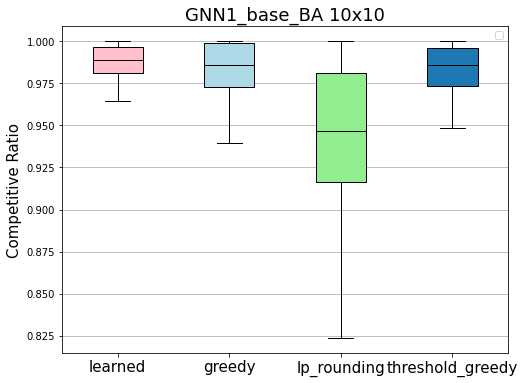

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


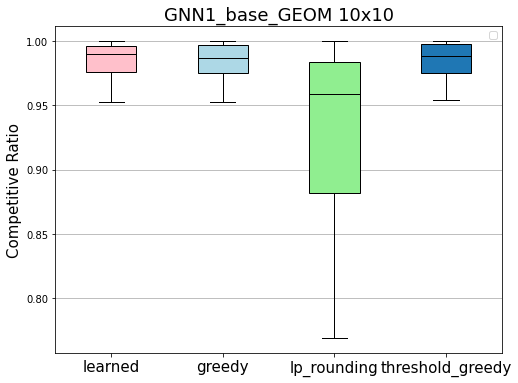

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


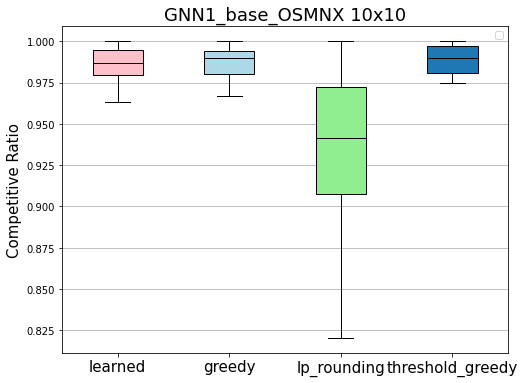

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


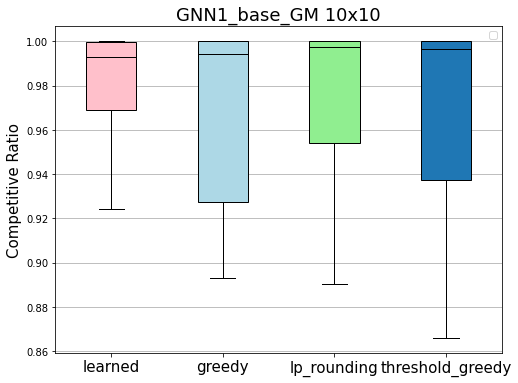

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


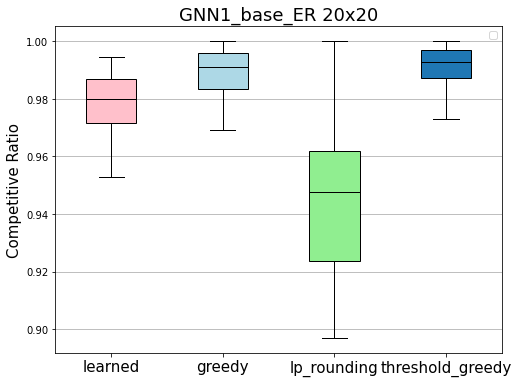

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


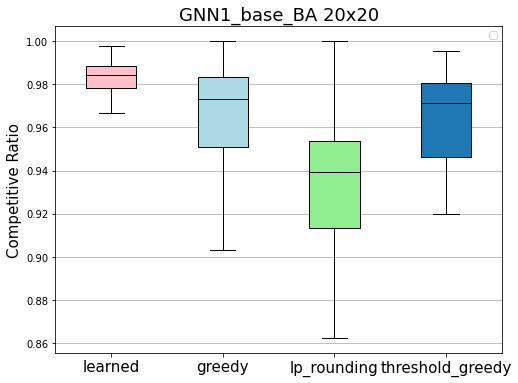

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


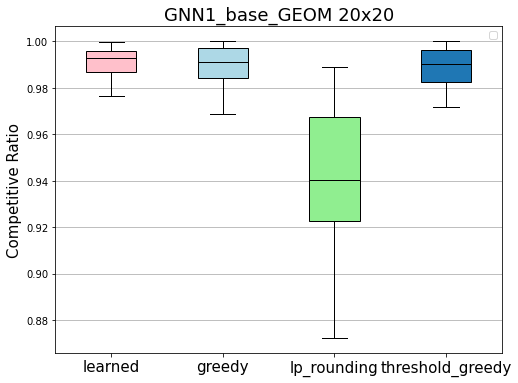

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


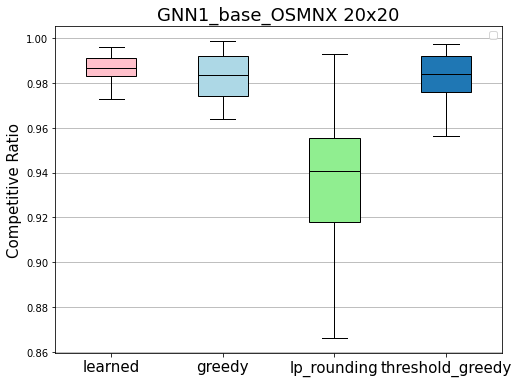

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


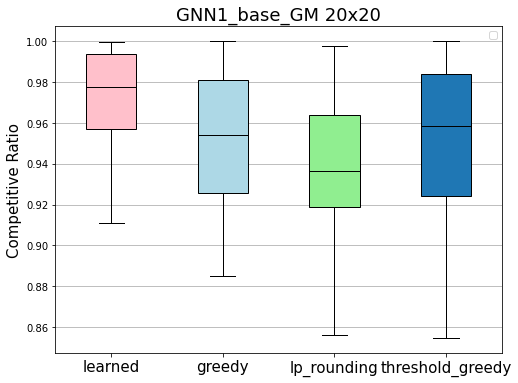

In [36]:
from util import _box_plots
for node_config in node_configs:
	_box_plots(data_copy[node_config], lambda graph_type: f"GNN1_base_{graph_type} {node_config[1]}x{node_config[0]}", colors = ['pink', 'lightblue', 'lightgreen'])

### Baseline ER/BA/GEOM evaluation

In [7]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 40, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

models = [("GNN", GNN)]

graph_configs = [
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    # {
    #     'graph_type': 'GEOM',
    #     'threshold': 0.2,
    #     'scaling': 1 / np.sqrt(2),
    #     'weighted': True
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


        rng = np.random.default_rng(seed)

        baselines = ['greedy']
        for model_name, model in models:
            cr_ratios = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[model],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                # baselines=['greedy', 'lp_rounding']
                baselines=baselines
            )

            baselines = []

            cr_ratios[model_name] = cr_ratios.pop("learned")

        data[graph_config['graph_type']].append(cr_ratios)

[0.25, 0.75, 1.25, 1.75, 2.25]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)


AttributeError: 'tuple' object has no attribute 'pop'

In [ ]:
from util import _plot_approx_ratios
_plot_approx_ratios(ratios, data, lambda graph_type: graph_type, confidence = 0.95)

In [ ]:
import matplotlib.pyplot as plt

ratios = [x/y for (x,y) in node_configs]

for graph_type, comp_ratios in data.items():
    aggregated_ratios = {}

    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

    fig = plt.figure(figsize=(8,6))
    for model, model_ratios in aggregated_ratios.items():
        plt.plot(ratios, model_ratios, label=model)

    title = f"{graph_type}"
    plt.title(title)
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/17_01_2024_{title}_no_probabilities.png")
    plt.show()


## Noise experiments

In [4]:
def create_noise_robust_models(noise_values):
    models = []
    for noise_value in noise_values:
        print(f"Training model for noise {noise_value}")
        args = {
        'processor':         'GENConv',
        'head':              'regression',
        'num_layers':        2,
        'num_mlp_layers':    2,
        'aggr':              'max',
        'batch_size':        32,
        'node_feature_dim':  5,
        'edge_feature_dim':  1,
        'graph_feature_dim': 2,
        'hidden_dim':        64,
        'output_dim':        1,
        'dropout':           0.35,
        'epochs':            25,
        'opt':               'adam',
        'opt_scheduler':     'none',
        'opt_restart':       0,
        'weight_decay':      5e-3,
        'lr':                0.0001,
        'device':            device,
        'noise':             noise_value # Set to 0 to not train on noisy features
        }

        train_num = 100; test_num = 30

        er_config = {
            'graph_type': 'ER',
            'p': 0.75,
            'weighted': True
        }
        ba_config = {
            'graph_type': 'BA',
            'ba_param': 2,
            'weighted': True
        }
        geom_config = {
            'graph_type': 'GEOM',
            'threshold': 0.2,
            'scaling': 1 / np.sqrt(2)
        }

        rng = np.random.default_rng()


        train_instances = [
                *ig.sample_instances(9, 7, train_num, rng, args, **er_config),
                *ig.sample_instances(9, 7, train_num, rng, args, **ba_config),
                *ig.sample_instances(9, 7, train_num, rng, args, **geom_config),
            ]

        test_instances = [
                *ig.sample_instances(9, 7, test_num, rng, args, **er_config),
                *ig.sample_instances(9, 7, test_num, rng, args, **ba_config),
                *ig.sample_instances(9, 7, test_num, rng, args, **geom_config),
            ]


        train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
        test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

        train_loader = DataLoader(
            train_data,
            batch_size=args['batch_size'],
            shuffle=True,
            num_workers=4
        )

        test_loader = DataLoader(
            test_data,
            batch_size=args['batch_size'],
            shuffle=True,
            num_workers=4
        )


        _, _, _, GNN, _ = train(train_loader, test_loader, args)
        models.append((f"GNN_{args['noise']}", GNN))
    return models

In [30]:
noise_values = np.linspace(0,5,20)
# models = create_noise_robust_models(noise_values)
models = [GNN] * len(noise_values) # TODO change this

In [31]:
num_trials = 80
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
node_config = (9,7)
graph_configs = [
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    # {
    #     'graph_type': 'GEOM',
    #     'threshold': 0.2,
    #     'scaling': 1 / np.sqrt(2),
    #     'weighted': True
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for noise_value, model in zip(noise_values, models):
        print(f"Evaluating model for noise {noise_value}")

        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)

        args['noise'] = noise_value
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)

        cr_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[model],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        data[graph_config['graph_type']].append(cr_ratios)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Evaluating model for noise 0.0
Evaluating model for noise 0.2631578947368421


/home/alexhay/GNN-OBM/algorithms.py:258: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix


Evaluating model for noise 0.5263157894736842
Evaluating model for noise 0.7894736842105263
Evaluating model for noise 1.0526315789473684
Evaluating model for noise 1.3157894736842104
Evaluating model for noise 1.5789473684210527
Evaluating model for noise 1.8421052631578947
Evaluating model for noise 2.1052631578947367
Evaluating model for noise 2.3684210526315788
Evaluating model for noise 2.631578947368421
Evaluating model for noise 2.894736842105263
Evaluating model for noise 3.1578947368421053
Evaluating model for noise 3.4210526315789473
Evaluating model for noise 3.6842105263157894
Evaluating model for noise 3.9473684210526314
Evaluating model for noise 4.2105263157894735
Evaluating model for noise 4.473684210526316
Evaluating model for noise 4.7368421052631575
Evaluating model for noise 5.0
Evaluating model for noise 0.0
Evaluating model for noise 0.2631578947368421
Evaluating model for noise 0.5263157894736842
Evaluating model for noise 0.7894736842105263
Evaluating model for 

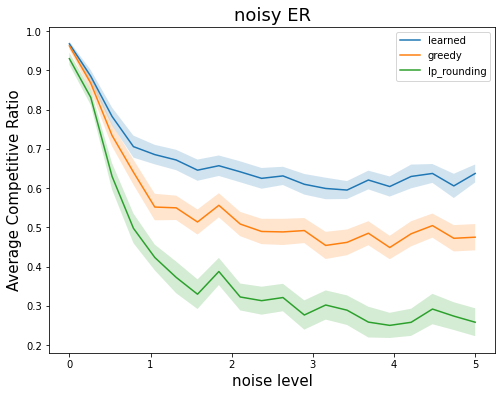

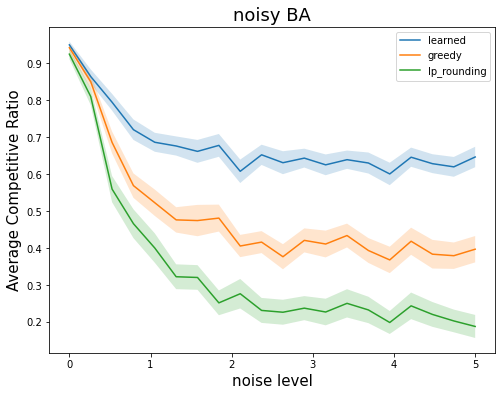

In [33]:
from util import _plot_approx_ratios
_plot_approx_ratios(noise_values, data, lambda graph_type: f"noisy {graph_type}", x_axis_name="noise level", confidence = 0.95)

## FEAT graph evaluation

In [ ]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.9,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.95,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    # plt.savefig(f"data/{title}.png")
    plt.show()


## OSMNX evaluation

In [ ]:
num_trials = 30
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

graph_configs = [
    {
        'graph_type': 'OSMNX',
        'location_graph': piedmont['location_graph'],
        'city': piedmont['city']
    },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': carmel['location_graph'],
    #     'city': carmel['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': geneva['location_graph'],
    #     'city': geneva['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': founex['location_graph'],
    #     'city': founex['city']
    # },
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['city']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        thresholded_greedy_ratios = [0]

        data[graph_config['city']].append(np.array(
            [
                gnn_learned_ratios,
                thresholded_greedy_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
print(ratios)
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[2]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[3]).mean())
        

    title = f"OSMNX_discard_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()



## Graph transferability

In [3]:
GNN, args = load('GNN2_hyperparam_tuned', device)

In [16]:
import gnn_library.util as util
import pickle
num_trials = 150
node_configs = [(2*x, x) for x in np.arange(10, 40, 2)]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]


threshold = 0.35 # TODO set up value
t_greedy = OBM_Threshold_Greedy(threshold) 


graph_configs = util.graph_configs_standard

sizes = [x for (x,y) in node_configs]
print(sizes)

data = [[] for _ in range(len(graph_configs))]

seed = 0
rng = np.random.default_rng(seed)

for data_index, graph_config in enumerate(graph_configs):
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)

        rng = np.random.default_rng(seed)

        cr_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        t_greedy_ratio, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[t_greedy],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
        )

        cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

        data[data_index].append(cr_ratios)
    

    with open(f"saved_runs/temp_transferability/transferability_gnn2.pickle", 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

[20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76]
(20, 10) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(24, 12) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(28, 14) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(32, 16) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix


(36, 18) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(40, 20) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(44, 22) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(48, 24) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(52, 26) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(56, 28) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(60, 30) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(64, 32) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(68, 34) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(72, 36) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(76, 38) {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
(20, 10) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(24, 12) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(28, 14) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(32, 16) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(36, 18) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(40, 20) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(44

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(24, 12) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(28, 14) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(32, 16) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(36, 18) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(40, 20) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(44, 22) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(48, 24) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(52, 26) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(56, 28) {'graph_type': 'GM'}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(60, 30) {'graph_type': 'GM'}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(64, 32) {'graph_type': 'GM'}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(68, 34) {'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(72, 36) {'graph_type': 'GM'}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(76, 38) {'graph_type': 'GM'}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
import pickle

with open(f"saved_runs/30_01_transferability_gnn2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
import pickle
with open(f'saved_runs/temp_transferability/transferability_gnn2.pickle', 'rb') as handle:
    data_copy = pickle.load(handle)

In [53]:
import gnn_library.util as util
graph_configs = util.graph_configs_standard

filtered_data = {}
for graph_config, val in zip(graph_configs, data_copy):
	if graph_config in util.graph_configs_main:
		filtered_data[frozenset(graph_config.items())] = val
print(filtered_data.keys())

filtered_data = {frozenset(g.items()): data for g, data in zip(graph_configs, data_copy)}

dict_keys([frozenset({('p', 0.5), ('graph_type', 'ER'), ('weighted', True)}), frozenset({('weighted', True), ('q', 0.25), ('d', 2), ('graph_type', 'GEOM')}), frozenset({('location', 'Fremont, California, USA'), ('graph_type', 'OSMNX')}), frozenset({('graph_type', 'GM')})])


In [54]:
len(list(filtered_data.values())[0])

15

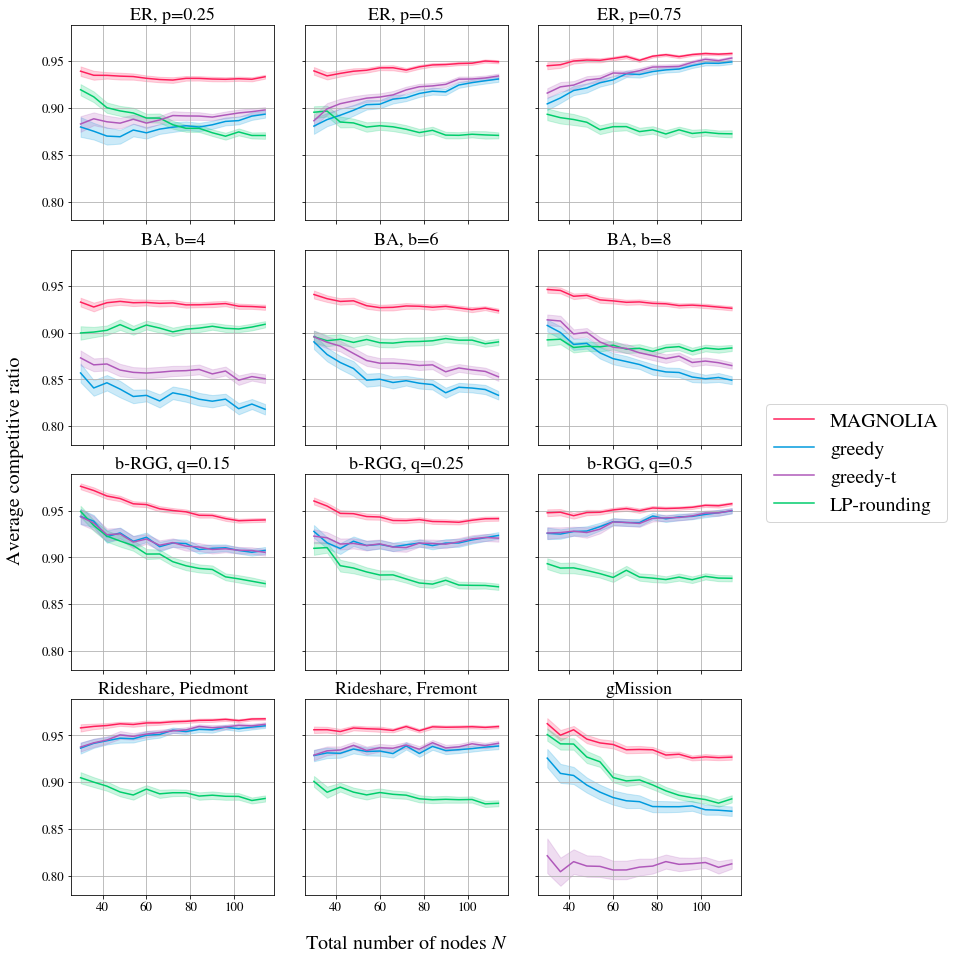

In [61]:
from util import _plot_approx_ratios_all
node_configs = [(2*x, x) for x in np.arange(10, 40, 2)]
sizes = [x+y for (x,y) in node_configs]
# for graph_config, graph_data in zip(graph_configs, data):
# 	formatted_data = {graph_config['graph_type']: graph_data}
_plot_approx_ratios_all(sizes, filtered_data, lambda graph_type: f"Generalization to node size {graph_config['graph_type']} for ratio {2}", x_axis_name= "Total number of nodes $N$", confidence = 0.95)

In [ ]:
import matplotlib.pyplot as plt

sizes = [x for (x,_) in node_configs]

aggregated_ratios = {}
for q, comp_ratios in data.items():
    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

fig = plt.figure(figsize=(8,6))
for model, ratios in aggregated_ratios.items():
    plt.plot(sizes, ratios, label=model)

title = f"16_01_2024_graph_transferability_{q}"
plt.title("Graph transferability NxN ratio - trained on 8x8")
plt.xlabel('Number of online nodes')
plt.ylabel('Average competitive ratio')
plt.legend()
plt.savefig(f"data/{title}.png")
plt.show()
